<font size=6>**FACE MORPHING DETECTION: CLASSIFICATORE I**</font>
</br><font size=3>*Roberto A. Usai, Davide Senette, Chiara Scalas*</font>



<p align="justify">In questo notebook, proponiamo un approccio combinato basato su <b>Local Binary Patterns (LBP)</b> e <b>Support Vector Machine (SVM)</b>. L'obiettivo principale è l'estrazione delle feature tramite la tecnica LBP, seguita dalla loro classificazione utilizzando un SVM. Questo metodo sfrutta la robustezza del LBP per catturare le caratteristiche locali delle immagini e l'efficacia del SVM per la classificazione, mirando a ottenere prestazioni superiori nell'analisi delle immagini.<br><br>In aggiunta, viene implementato un metodo di feature extraction custom basato sul comportamento della luce nelle immagini. Alla fine del notebook è presente anche una sezione per eseguire il tuning del modello.</p>

**Indice:**
*   [Import librerie e impostazioni](#1)
*   [Dataset](#2)
*   [Estrazione delle feature](#3)
*   [Definizione SVM + Funzione Risultati](#4)
*   [Classificatore LBP + SVM](#5)
*   [Classificatore LBP + Light + SVM](#6)
*   [Tuning SVM](#7)

<a name="1"></a>
# **Installazioni, import librerie e parametri globali**

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize, StandardScaler
from skimage.feature import local_binary_pattern
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.svm import SVC
from skimage import feature
import numpy as np
import joblib
import shutil
import random
import gdown
import json
import sys
import cv2
import os

Prima importiamo le librerie, poi montiamo Google Drive per poter accedere facilmente agli altri file.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Path della cartella del progetto su Google Drive:

#@markdown <font color="#ed7d31"><b>Necessario per poter accedere agli altri file</b>!</font>
#@markdown <br>Se la cartella del progetto si trova nella root di Drive, scrivere solo il suo nome:
DRIVE_PATH = "MAD Project" #@param {type:"string"}

DRIVE_PATH = '/content/drive/MyDrive/' + DRIVE_PATH

WEIGHTS_PATH = DRIVE_PATH + '/Weights/'

In [ ]:
sys.path.append(DRIVE_PATH)                       # ci permetterà di importare le funzioni presenti in altri file
from shared_utilities import download_dataset, move_files, split_dataset

Scarichiamo dal file .json gli ID necessari per il download del dataset e del csv.

In [ ]:
with open(DRIVE_PATH + '/settings.json', 'r') as file:
  config = json.load(file)

DATASET_ID = config['DATASET_ID']

In [ ]:
#@title Caricamento di un dataset custom

#@markdown Inserire l'ID del dataset custom. Qualora si volesse usare l'originale, lasciare vuoto.
DATASET_CUSTOM = "1zhWDht4hxcnVu08K6si9RfXZuEfcWxRh" #@param {type:"string"}

if DATASET_CUSTOM != "":
  DATASET_ID = DATASET_CUSTOM

In [ ]:
#@title Impostazioni del Notebook

#@markdown Seme per le funzioni randomiche del notebook:
SEED = 2407 #@param {type:"integer"}

random.seed(SEED)

np.set_printoptions(suppress=True) # NumPy non utilizzerà la notazione scientifica per piccoli numeri, rendendo l'output più leggibile.

<a name="2"></a>
# **Dataset**


## Download

In [ ]:
#@title Impostazioni download

#@markdown Nome del zip dataset post download:
DATASET_NAME = 'AMSL_dataset.zip' #@param {type:"string"}

download_dataset(DATASET_ID, DATASET_NAME, msg=True)

Downloading...
From: https://drive.google.com/uc?id=1zhWDht4hxcnVu08K6si9RfXZuEfcWxRh
To: /content/AMSL_dataset.zip
100%|██████████| 17.0M/17.0M [00:00<00:00, 43.2MB/s]


File scaricato e salvato come AMSL_dataset.zip!



Dopo aver scaricato il dataset lo manipoliamo in modo da unzipparlo, creare le directory per gli split e infine eliminare i file txt e la cartella sample_data creata automaticamente da Colab.

In [ ]:
%%capture
# evita il fastidioso output a video

! unzip "{DATASET_NAME}"                                  # unzippa il file zip
! rm /content/AMSL/*.txt                                  # elimina i file txt
! rm -r /content/sample_data                              # elimina la cartella di default di Colab

if DATASET_CUSTOM == "":                                  # se il dataset è l'originale
  ! mv /content/AMSL/neutral/* /content/AMSL/smiling      # sposta i file della cartella neutral in smiling
  ! mv /content/AMSL/smiling /content/AMSL/bona_fide      # rinomina smiling in bona_fide
  ! rmdir AMSL/neutral                                    # rimuove la cartella neutral (ormai vuota)

<a name="2"></a>
## Split

In [ ]:
#@title Parametri dello split
#@markdown Percentuale di split per il test set:
TEST = 20 #@param  {type:"integer"}

#@markdown Percentuale di split per il validation set:
VAL = 20 #@param  {type:"integer"}

path_dataset = '/content/AMSL'

bona_fide_count = len(os.listdir(os.path.join(path_dataset,'bona_fide')))
morphed_count = len(os.listdir(os.path.join(path_dataset,'morphed')))

# path delle cartelle su Colab
test = '/content/Dataset/test/'
val = '/content/Dataset/val/'
train = '/content/Dataset/train/'

split_dataset(path_dataset=path_dataset, train=train, val=val, test=test, bona_fide_count=bona_fide_count, morphed_count=morphed_count, VAL=VAL, TEST=TEST)

In [ ]:
print("Immagini di test:\n-Bona Fide:\t%d\n-Morphed:\t%d\n" % (len(os.listdir('/content/Dataset/test/bona_fide')), len(os.listdir('/content/Dataset/test/morphed'))) )

print("Immagini di training:\n-Bona Fide:\t%d\n-Morphed:\t%d\n" % (len(os.listdir('/content/Dataset/train/bona_fide')), len(os.listdir('/content/Dataset/train/morphed'))) )

print("Immagini di validation:\n-Bona Fide:\t%d\n-Morphed:\t%d\n" % (len(os.listdir('/content/Dataset/val/bona_fide')), len(os.listdir('/content/Dataset/val/morphed'))) )

Immagini di test:
-Bona Fide:	245
-Morphed:	265

Immagini di training:
-Bona Fide:	734
-Morphed:	796

Immagini di validation:
-Bona Fide:	245
-Morphed:	265



<a name="3"></a>
# **Estrazione delle feature**

Definiamo la classe LocalBinaryPatterns con i metodi necessari all'esecuzione della tecnica.

In [ ]:
class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
        self.numPoints = numPoints
        self.radius = radius

    def describe(self, image, eps=1e-7):
        lbp = feature.local_binary_pattern(image, self.numPoints, self.radius, method="uniform")

        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, self.numPoints + 3), range=(0, self.numPoints + 2))

        hist = hist.astype("float")
        hist /= (hist.sum() + eps)

        return hist

def calculate_light_average(image):
  # calcolo delle medie
  height, width = image.shape
  average_image = np.zeros((height, width), dtype=np.uint8)
  offsets = [(-1, -1), (0, -1), (1, -1),
              (-1,  0),          (1,  0),
              (-1,  1), (0,  1), (1,  1)]

  for y in range(1, height-1):
      for x in range(1, width-1):
          neighbor_values = [image[y, x]]
          for oy, ox in offsets:
              neighbor_values.append(image[y + oy, x + ox])

          average_value = int(np.mean(neighbor_values))
          average_image[y, x] = average_value

  average_hist, _ = np.histogram(average_image.ravel(), bins=256, range=(0, 256))
  average_hist = average_hist.astype("float")
  average_hist /= (average_hist.sum() + 1e-7)

  return average_hist

In [ ]:
lista_immagini_test = []

def extract_lbp_features(dataset,filter_light, radius=2, numPoints=16, prendi_lista = False):
  desc = LocalBinaryPatterns(numPoints, radius)

  # lista per conservare le feature e le etichette
  data = []
  labels = []

  # dizionario per mappare le etichette ai numeri
  label_mapping = {'bona_fide': 0, 'morphed': 1}

  for label in ['bona_fide', 'morphed']:
    label_path = os.path.join(dataset, label)

    for image_name in os.listdir(label_path):
      image_path = os.path.join(label_path, image_name)
      if prendi_lista:
        lista_immagini_test.append(image_path)

      image = cv2.imread(image_path) # carica l'immagine

      gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # converte l'immagine in scala di grigi

      hist = desc.describe(gray_image) # estrae le feature usando LBP

      if filter_light:
        # estrai le feature
        features_light = calculate_light_average(gray_image)

        features = np.concatenate((hist, features_light))
      else:
        features = hist

      data.append(features)
      labels.append(label_mapping[label])

  data = np.array(data)
  labels = np.array(labels)

  return data, labels

def create_newTrainTest_extract(filter_light = False):
  # estrazione delle caratteristiche con LBP
  data_train, labels_train = extract_lbp_features(train,filter_light)
  data_val, labels_val = extract_lbp_features(val,filter_light)
  data_test, labels_test = extract_lbp_features(test, filter_light, prendi_lista= True)

  scaler = StandardScaler() # per standardizzare i dati
  scaler.fit(data_train)    # calcola media e varianza

  # applica la trasformazione
  train_features = scaler.transform(data_train)
  val_features = scaler.transform(data_val)
  test_features = scaler.transform(data_test)

  return train_features,labels_train, val_features,labels_val,test_features,labels_test

<a name="4"></a>
# **Definizione SVM + Funzione Risultati**


Definiamo la funzione per istanziare e addestrare un modello SVM e la funzione per stampare i risultati sotto forma di plot.

In [ ]:
def SVM_classifier(train_x, train_y, best_param):
  '''
  Funzione per definire e addestrare un classificatore SVM.

  Parametri:
  - train_x: le feature di addestramento.
  - train_y: le etichette di addestramento.
  - best_param: un dizionario di parametri ottimali per il classificatore SVM.
  '''

  # utilizza i parametri ottimali se forniti nel dizionario, altrimenti utilizza i valori di default
  if best_param.get('kernel') == 'linear':
    svm_clf = SVC(C=best_param.get('C'), kernel=best_param.get('kernel')) # il kernel lineare non ha il parametro gamma
  else:
    svm_clf = SVC(C=best_param.get('C'), kernel=best_param.get('kernel'), gamma=best_param.get('gamma'))

  svm_clf.fit(train_x, train_y) # addestra il modello

  return svm_clf

In [ ]:
def Plot_risultati_SVM(label_predict, test_y, best_param_svm):
  fig = plt.figure(num="Valutazione del Modello", figsize=(10, 4))

  axs = fig.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]}) # 1×3

  unique_labels = np.unique(test_y) # estrae etichette

  matrice_confusione = confusion_matrix(test_y, label_predict, labels=unique_labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=matrice_confusione, display_labels=unique_labels)

  # plotta la matrice di confusione nella prima colonna
  im = axs[0].imshow(matrice_confusione, interpolation='nearest', cmap=plt.cm.Blues)
  disp.plot(ax=axs[0], cmap=plt.cm.Blues, colorbar=False)
  axs[0].set_title('Matrice di Confusione')

  # aggiunge una barra di colore per la matrice di confusione
  cbar = fig.colorbar(im, ax=axs[0])
  cbar.set_label('Intensità')

  best_c = best_param_svm.get('C')
  best_kernel = best_param_svm.get('kernel')
  best_gamma = best_param_svm.get('gamma')

  fig.text(0.5, 0.75, f'Best C: {best_c}', ha='center', va='center', fontsize=11, color='black')
  fig.text(0.5, 0.70, f'Best Kernel: {best_kernel}', ha='center', va='center', fontsize=11, color='black')
  if best_gamma is not None:
    fig.text(0.5, 0.65, f'Best Gamma: {best_gamma}', ha='center', va='center', fontsize=11, color='black')

  # calcola la curva ROC
  fpr, tpr, _ = roc_curve(test_y, label_predict)
  roc_auc = auc(fpr, tpr)

  # plotta la curva ROC nella terza colonna
  axs[2].plot(fpr, tpr, color='darkorange', lw=2, label='Area = {0:0.2f}'.format(roc_auc))
  axs[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  axs[2].set_xlabel('False Positive Rate')
  axs[2].set_ylabel('True Positive Rate')
  axs[2].set_title('Curva ROC')
  axs[2].legend(loc="lower right", fontsize=7)

  axs[1].axis('off') # rimuove gli assi vuoti nella seconda colonna

  axs[2].set_aspect('equal', adjustable='box')  # aggiusta gli assi per la curva ROC in modo da adattarsi alla finestra

  # calcolo metriche di valutazione
  accuracy = accuracy_score(test_y, label_predict)
  precision = precision_score(test_y, label_predict)
  recall = recall_score(test_y, label_predict)
  F_score = f1_score(test_y, label_predict)

  size = 11
  # aggiunge il testo delle metriche nel plot
  fig.text(0.5, 0.60, f'Accuracy: {accuracy:.3f}', ha='center', va='center', fontsize=size, color='blue')
  fig.text(0.5, 0.55, f'Error Rate: {1-accuracy:.3f}', ha='center', va='center', fontsize=size, color='red')
  fig.text(0.5, 0.50, f'Recall: {recall:.3f}', ha='center', va='center', fontsize=size, color='green')
  fig.text(0.5, 0.45, f'Precision: {precision:.3f}', ha='center', va='center', fontsize=size, color='orange')
  fig.text(0.5, 0.40, f'F1-score: {F_score:.3f}', ha='center', va='center', fontsize=size, color='cyan')

  plt.tight_layout()
  plt.show()

<a name="5"></a>
# **Classificatore LBP + SVM**

## Addestramento (o caricamento)

In [ ]:
#@title Impostazioni SVM
Carica_modello = False #@param {type: "boolean"}

In [ ]:
#carico il train e il test usando LBP
train_features,labels_train, _,_,test_features,labels_test = create_newTrainTest_extract()

# Migliori parametri ottenuti con il tuning
parametri = {'C': 100, 'gamma': 0.025, 'kernel': 'rbf'}

In [ ]:
if Carica_modello:
  model_svm = joblib.load('/content/drive/MyDrive/MAD Project/Models/svm_modelOnlyLBP.pkl') # carica il modello
else:
  model_svm = SVM_classifier(train_features,labels_train, parametri) # addestra il modello

pred_y = model_svm.predict(test_features) # effettua le previsioni

Con la seguente istruzione è possibile salvare il modello su Drive in modo da poterlo ricaricare in un secondo momento.

In [ ]:
joblib.dump(model_svm, '/content/drive/MyDrive/MAD Project/Models/svm_modelOnlyLBP.pkl') # salva il modello addestrato in un file

['/content/drive/MyDrive/MAD Project/Models/svm_modelOnlyLBP.pkl']

## Plot risultati

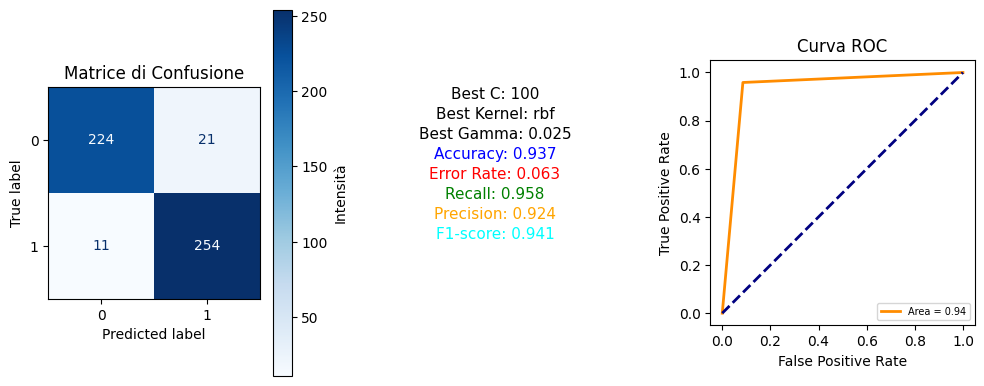

In [ ]:
Plot_risultati_SVM(pred_y, labels_test, parametri)

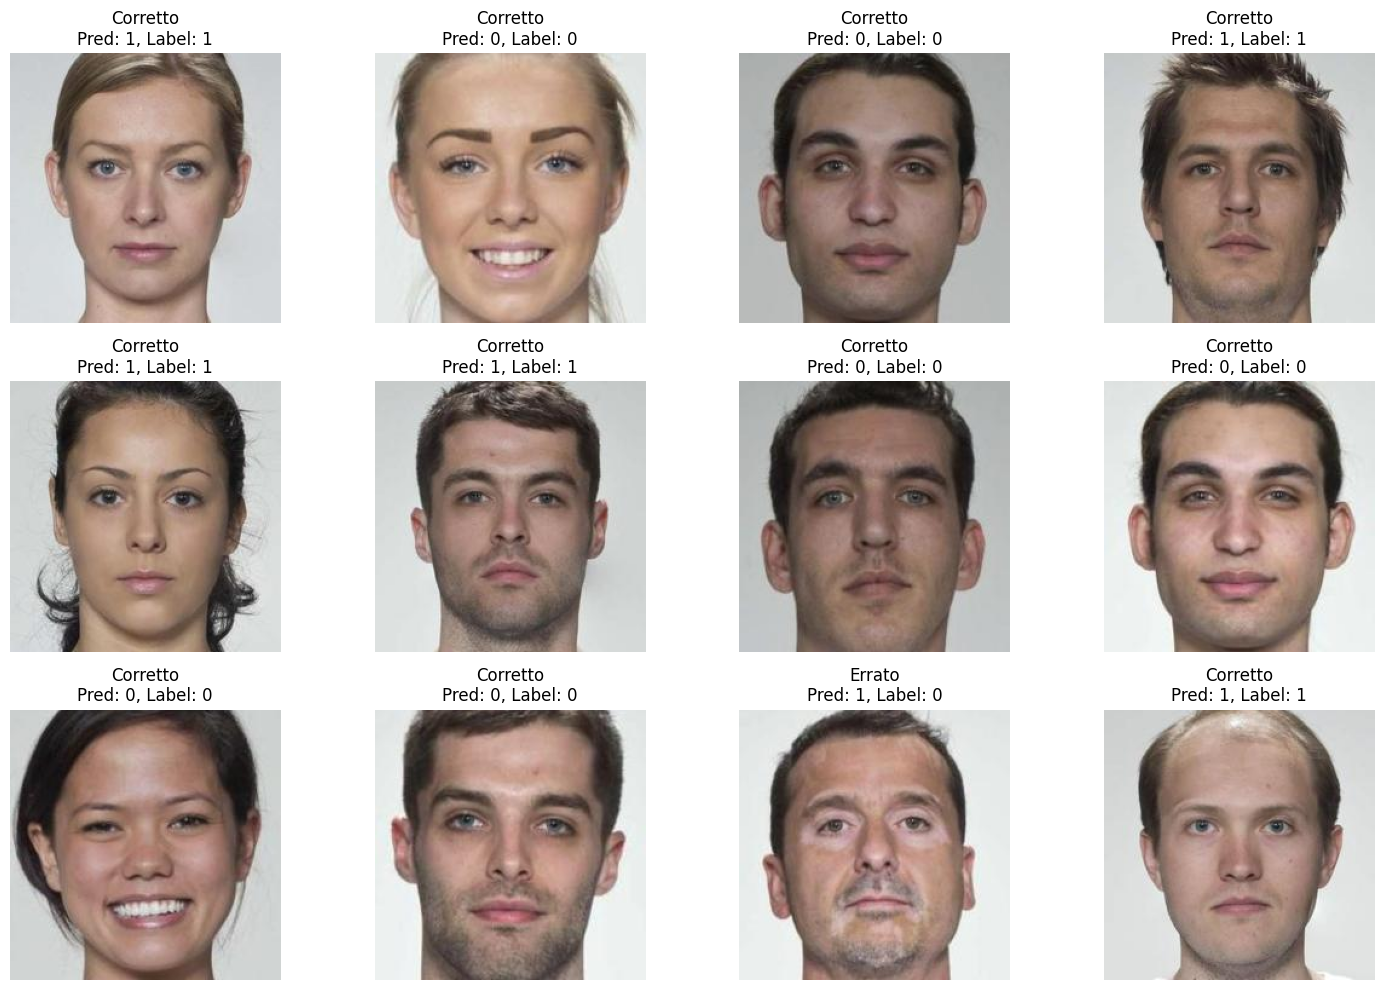

In [ ]:
correct_images_label_0 = []
correct_images_label_1 = []
incorrect_images = []
count = 0

# scorre le immagini e seleziona quelle corrette e quelle errate con etichette miste
for i in range(len(test_features)):
    if labels_test[i] != pred_y[i] and len(incorrect_images) < 1:
        incorrect_images.append((lista_immagini_test[i], pred_y[i], labels_test[i]))
        count += 1
    elif labels_test[i] == pred_y[i] and len(correct_images_label_0) < 6 and pred_y[i] == 0:
        correct_images_label_0.append((lista_immagini_test[i], pred_y[i], labels_test[i]))
        count += 1
    elif labels_test[i] == pred_y[i] and len(correct_images_label_1) < 5 and pred_y[i] == 1:
        correct_images_label_1.append((lista_immagini_test[i], pred_y[i], labels_test[i]))
        count += 1

    # ferma il ciclo se hai trovato tutte le immagini necessarie
    if count == 12:  # deve essere 12 per includere l'immagine errata
        break

# combina le liste delle immagini corrette e fai uno shuffle
all_images = correct_images_label_0 + correct_images_label_1 + incorrect_images
random.shuffle(all_images)

# plotta le immagini usando subplot
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.ravel()  # Flatten the 2D array of axes to a 1D array for easier iteration

# plotta le immagini
for idx, (img_path, pred, label) in enumerate(all_images):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    title = "Corretto" if pred == label else "Errato"
    axes[idx].imshow(image)
    axes[idx].set_title(f"{title}\nPred: {pred}, Label: {label}")
    axes[idx].axis('off')

# nasconde gli assi non utilizzati se ce ne sono
for ax in axes[len(all_images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

<a name="6"></a>
# **Classificatore LBP + Light + SVM**

## Addestramento (o caricamento)

In [ ]:
#@title Impostazioni SVM
Carica_modello = False #@param {type: "boolean"}

In [ ]:
train_features1, labels_train1, val_features1, val_labels1, test_features1, labels_test1 = create_newTrainTest_extract(filter_light = True) # carico il train e il test usando LBP

parametri = {'C': 10, 'gamma': 0.025, 'kernel': 'rbf'} # migliori iperparametri ottenuti con il tuning

In [ ]:
if Carica_modello:
  model_svm = joblib.load('/content/drive/MyDrive/MAD Project/Models/svm_modelLBPAndLight.pkl') # carica il modello
else:
  model_svm = SVM_classifier(train_features1,labels_train1, parametri) # addestra il modello

pred_y1 = model_svm.predict(test_features1) # effettua le previsioni

Con la seguente istruzione è possibile salvare il modello su Drive in modo da poterlo ricaricare in un secondo momento.

In [ ]:
joblib.dump(model_svm, '/content/drive/MyDrive/MAD Project/Models/svm_modelLBPAndLight.pkl') # salva il modello addestrato in un file

['/content/drive/MyDrive/MAD Project/Models/svm_modelLBPAndLight.pkl']

## Plot risultati

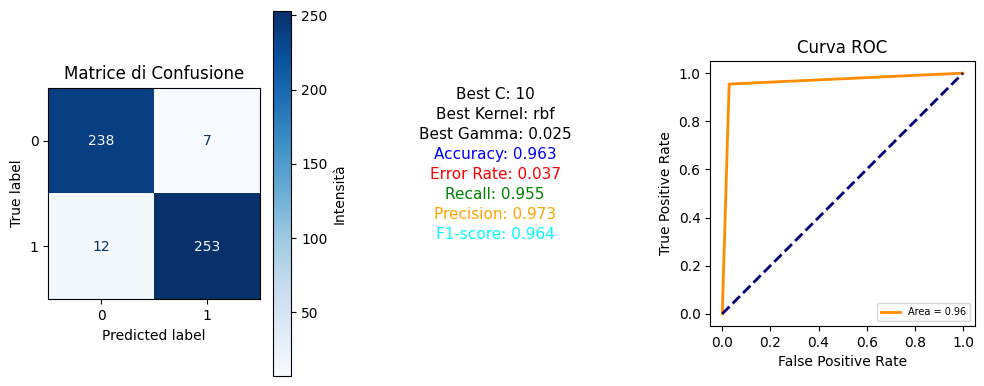

In [ ]:
Plot_risultati_SVM(pred_y1, labels_test1, parametri)

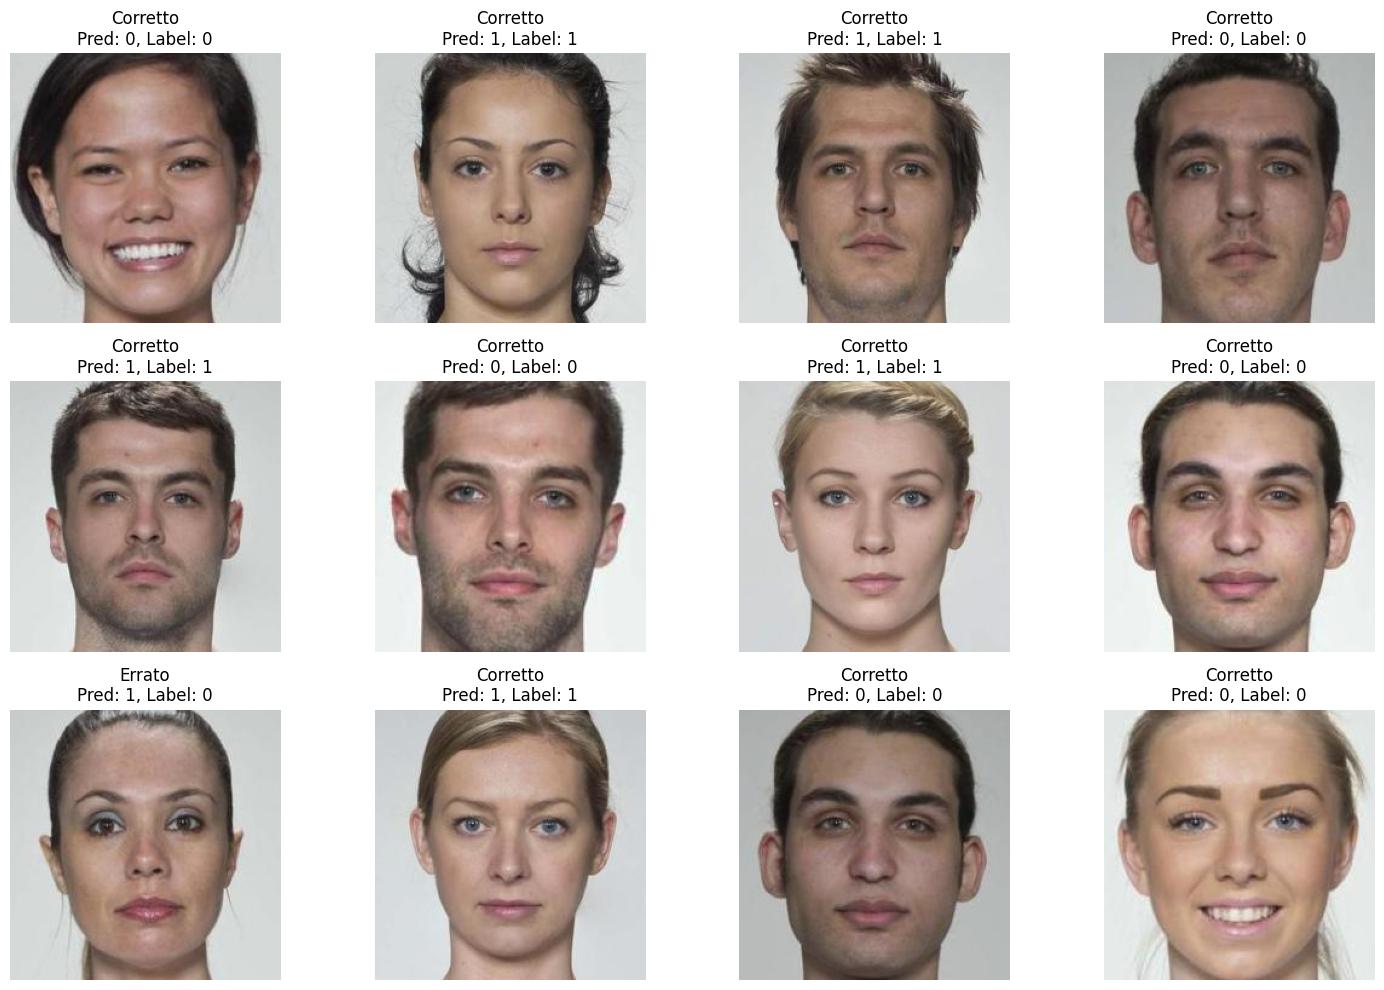

In [ ]:
correct_images_label_0 = []
correct_images_label_1 = []
incorrect_images = []
count = 0

# scorre le immagini e seleziona quelle corrette e quelle errate con etichette miste
for i in range(len(test_features)):
    if labels_test1[i] != pred_y1[i] and len(incorrect_images) < 1:
        incorrect_images.append((lista_immagini_test[i], pred_y1[i], labels_test1[i]))
        count += 1
    elif labels_test1[i] == pred_y1[i] and len(correct_images_label_0) < 6 and pred_y1[i] == 0:
        correct_images_label_0.append((lista_immagini_test[i], pred_y1[i], labels_test1[i]))
        count += 1
    elif labels_test1[i] == pred_y1[i] and len(correct_images_label_1) < 5 and pred_y1[i] == 1:
        correct_images_label_1.append((lista_immagini_test[i], pred_y1[i], labels_test1[i]))
        count += 1

    # ferma il ciclo se hai trovato tutte le immagini necessarie
    if count == 12:  # Deve essere 12 per includere l'immagine errata
        break

# combina le liste delle immagini corrette e fai uno shuffle
all_images = correct_images_label_0 + correct_images_label_1 + incorrect_images
random.shuffle(all_images)

# plotta le immagini usando subplot
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.ravel()  # Flatten the 2D array of axes to a 1D array for easier iteration

# plotta le immagini
for idx, (img_path, pred, label) in enumerate(all_images):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    title = "Corretto" if pred == label else "Errato"
    axes[idx].imshow(image)
    axes[idx].set_title(f"{title}\nPred: {pred}, Label: {label}")
    axes[idx].axis('off')

# nascondi gli assi non utilizzati se ce ne sono
for ax in axes[len(all_images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

<a name="7"></a>
# **Tuning SVM**

In questa sezione è possibile eseguire il tuning degli iperparametri al fine di trovare la configurazione più performante.

In [ ]:
train_features, labels_train, val_features, labels_val, test_features, labels_test = create_newTrainTest_extract(filter_light = False)

# concatenazione dei dati e delle etichette
train_data_combined = np.concatenate((train_features, val_features), axis=0)
train_labels_combined = np.concatenate((labels_train, labels_val), axis=0)

In [ ]:
def gridSearchSVM(train_x, train_y, param_grid):
  '''
  Funzione per effettuare la ricerca dei migliori iperparametri per un classificatore SVM utilizzando la Cross-validation.

  Parametri:
  - train_x: le feature di addestramento.
  - train_y: le etichette di addestramento.
  - param_grid: dizionario di iperparametri per la ricerca.
  '''

  svm_clf = SVC() # creazione di un classificatore di tipo SVM

  n_folds = 10 # numero di fold per la Cross-validation

  grid_search_cv = GridSearchCV(svm_clf, param_grid, cv=n_folds, scoring='f1_macro')
  grid_search_cv.fit(train_x, train_y)

  risultati = grid_search_cv.cv_results_ # ottiene i risultati

  migliori_parametri = grid_search_cv.best_params_ # trova i migliori iperparametri

  best_f1_score = grid_search_cv.best_score_ # trova la migliore accuratezza

  return migliori_parametri, best_f1_score


def tuning_SVM(train_x, train_y):
  '''
  Funzione per effettuare il tuning di un classificatore SVM utilizzando la Cross-validation.

  Parametri:
  - train_x: le feature di addestramento.
  - train_y: le etichette di addestramento.
  '''

  param_grid_linear = [{'kernel': ['linear'], 'C': [0.01, 0.1, 1, 10, 100]}] # creazione della griglia di iperparametri per SVM lineare

  param_grid_rbf = [{'kernel': ['rbf'], 'C': [0.01, 0.1, 1, 10, 100], 'gamma': [0.025,0.05,]}] # creazione della griglia di iperparametri per SVM con RBF

  param_tuning_linear, F1_tuning_linear = gridSearchSVM(train_x, train_y, param_grid_linear) # risultato per tuning SVM lineare con ottimizzazione di C

  param_tuning_rbf, F1_tuning_rbf = gridSearchSVM(train_x, train_y, param_grid_rbf) # risultato per tuning SVM con kernel RBF con ottimizzazione di C e gamma

  # trovo il migliore e lo restituisco
  if(F1_tuning_linear > F1_tuning_rbf):
      return param_tuning_linear
  else:
      return param_tuning_rbf

In [ ]:
best_param_svm = tuning_SVM(train_data_combined,train_labels_combined) # cerca i migliori parametri per il nostro classificatore SVM

print(best_param_svm)

{'C': 100, 'gamma': 0.025, 'kernel': 'rbf'}
